In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras import models, layers, regularizers


In [2]:
np.random.seed(42)

In [3]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [4]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")

In [5]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)
 
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [8]:
batch_size = 8
lr = 1e-4
num_epochs = 100
dataset_path="/kaggle/input/brain-tumor-segmentation"
model_path = os.path.join("files", "attention_res_unet_best.keras")
csv_path = os.path.join("files", "log.csv")

In [9]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (1840,1840)
Valid: (612,612)
Test: (612,612)


In [10]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, 
                                     MaxPooling2D, UpSampling2D, Concatenate, 
                                     Input, Add, Multiply)
from tensorflow.keras.models import Model

def conv_block(x, filters):
    """Residual convolutional block"""
    shortcut = x
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters, (1, 1), padding="same")(shortcut)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

def attention_gate(x, g):
    """Attention Gate"""
    filters = x.shape[-1]
    g = Conv2D(filters, (1, 1), padding="same")(g)
    x = Conv2D(filters, (1, 1), padding="same")(x)
    attn = Add()([x, g])
    attn = Activation("relu")(attn)
    attn = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(attn)
    return Multiply()([x, attn])

def attention_resunet(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = conv_block(p4, 1024)
    
    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    a6 = attention_gate(c4, u6)
    u6 = Concatenate()([u6, a6])
    c6 = conv_block(u6, 512)
    
    u7 = UpSampling2D((2, 2))(c6)
    a7 = attention_gate(c3, u7)
    u7 = Concatenate()([u7, a7])
    c7 = conv_block(u7, 256)
    
    u8 = UpSampling2D((2, 2))(c7)
    a8 = attention_gate(c2, u8)
    u8 = Concatenate()([u8, a8])
    c8 = conv_block(u8, 128)
    
    u9 = UpSampling2D((2, 2))(c8)
    a9 = attention_gate(c1, u9)
    u9 = Concatenate()([u9, a9])
    c9 = conv_block(u9, 64)
    
    outputs = Conv2D(num_classes, (1, 1), activation="sigmoid")(c9)
    
    return Model(inputs, outputs)

# Create model
model = attention_resunet()
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 128)  │          8,320 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 34,193,797 (130.44 MB)

 Trainable params: 34,182,021 (130.39 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [12]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ]

In [13]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=1,
    )

Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9366 - dice_coef: 0.3299 - loss: 0.6701
Epoch 1: val_loss improved from inf to 0.99999, saving model to files/attention_res_unet_best.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 137s 389ms/step - accuracy: 0.9368 - dice_coef: 0.3303 - loss: 0.6697 - val_accuracy: 0.9823 - val_dice_coef: 1.1782e-05 - val_loss: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9851 - dice_coef: 0.5585 - loss: 0.4415
Epoch 2: val_loss improved from 0.99999 to 0.76140, saving model to files/attention_res_unet_best.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 76s 332ms/step - accuracy: 0.9851 - dice_coef: 0.5586 - loss: 0.4414 - val_accuracy: 0.9822 - val_dice_coef: 0.2380 - val_loss: 0.7614 - learning_rate: 1.0000e-04
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9873 - dice_coef: 0.6312 - loss: 0.3688
Epoch 3: val_loss improved from 0.76140 to 0.40861, saving model to files/attent

In [14]:
import pandas as pd
metrics = pd.read_csv("/kaggle/working/files/log.csv")
metrics

,epoch,accuracy,dice_coef,learning_rate,loss,val_accuracy,val_dice_coef,val_loss
0,0,0.971066,0.426490,1.000000e-04,0.573510,0.982256,0.000012,0.999988
1,1,0.985942,0.576572,1.000000e-04,0.423428,0.982174,0.238027,0.761404
2,2,0.988181,0.647129,1.000000e-04,0.352871,0.987159,0.590862,0.408610
3,3,0.989668,0.692644,1.000000e-04,0.307356,0.988847,0.645604,0.353303
4,4,0.990297,0.716243,1.000000e-04,0.283757,0.989455,0.669143,0.330760
5,5,0.991449,0.751272,1.000000e-04,0.248728,0.991382,0.742232,0.258183
6,6,0.992168,0.774315,1.000000e-04,0.225685,0.991234,0.749877,0.250317
7,7,0.992886,0.796254,1.000000e-04,0.203746,0.990197,0.689139,0.311108
8,8,0.993343,0.810485,1.000000e-04,0.189515,0.990423,0.707210,0.292959
9,9,0.993641,0.821413,1.000000e-04,0.178587,0.990419,0.717194,0.282819


<Axes: >

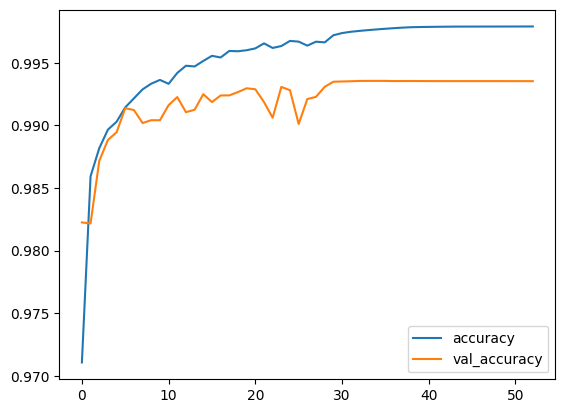

In [15]:
metrics[['accuracy','val_accuracy']].plot()

<Axes: >

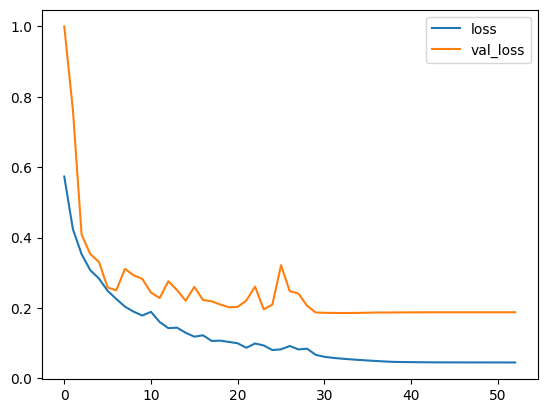

In [16]:
metrics[['loss','val_loss']].plot()

In [17]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [18]:
results = model.evaluate(test_dataset)

# Print Results
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[2]:.4f}")
print(f"Test Dice Coefficient: {results[1]*100:.4f}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9932 - dice_coef: 0.8072 - loss: 0.1929
Test Loss: 0.2015
Test Accuracy: 0.9933
Test Dice Coefficient: 79.9382


In [19]:
from tqdm import tqdm
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)
    '''
    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)
    '''

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv", index=None)

100%|██████████| 612/612 [01:45<00:00,  5.79it/s]

F1: 0.74433
Jaccard: 0.66369
Recall: 0.74380
Precision: 0.79460


In [20]:
scores = pd.read_csv("/kaggle/working/files/score.csv")
scores

,Image,F1,Jaccard,Recall,Precision
0,833.png,0.920635,0.852941,0.919014,0.922261
1,2069.png,0.858845,0.752610,0.996809,0.754428
2,3038.png,0.759883,0.612751,0.808411,0.716851
3,1169.png,0.954774,0.913462,0.921336,0.990730
4,501.png,0.951601,0.907670,0.941090,0.962349
...,...,...,...,...,...
607,1675.png,0.809035,0.679310,0.800813,0.817427
608,429.png,0.964318,0.931094,0.963458,0.965179
609,344.png,0.959648,0.922427,0.942700,0.977217
610,2667.png,0.880071,0.785827,0.807008,0.967679


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


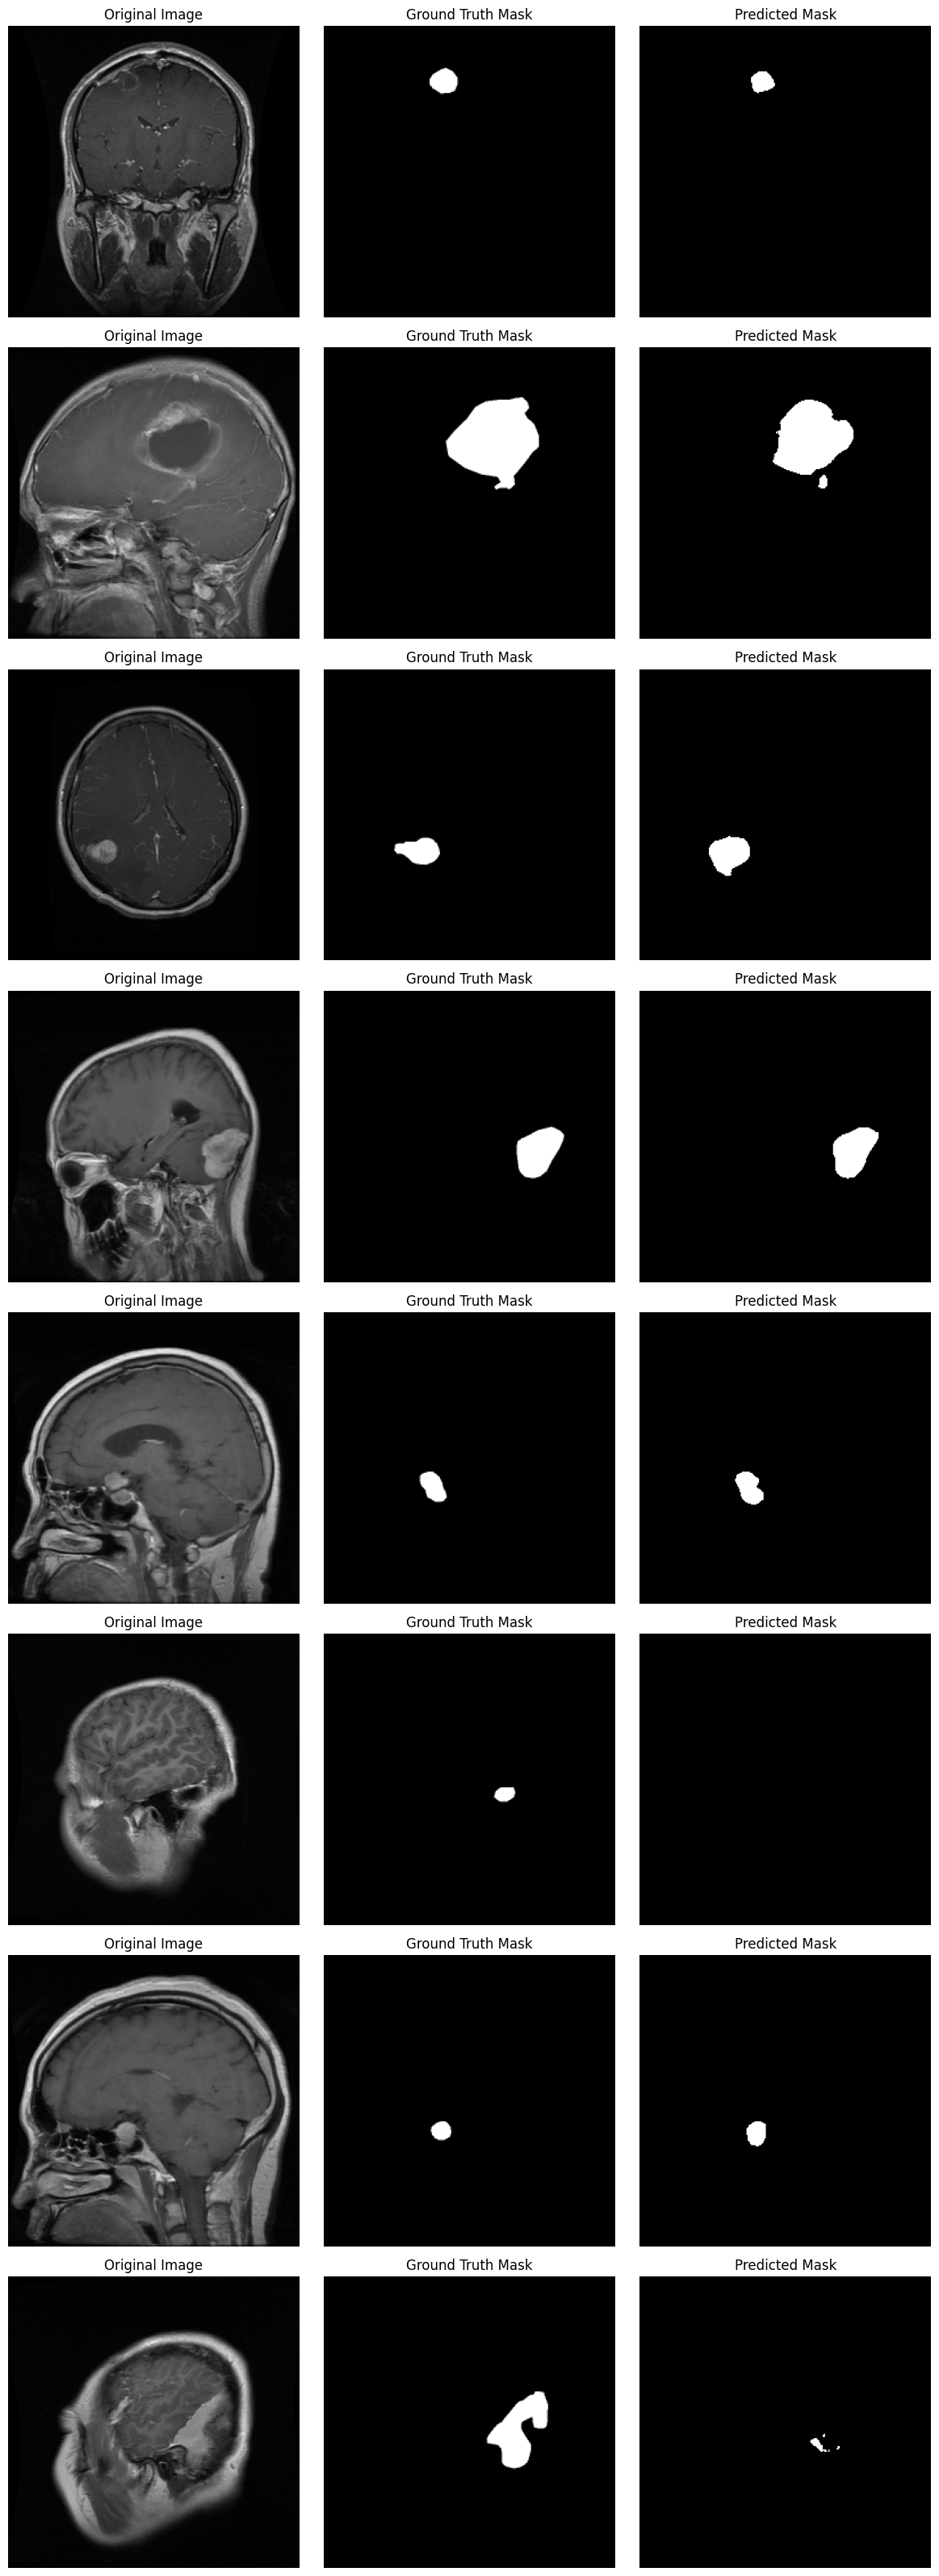

In [21]:
import matplotlib.pyplot as plt
import numpy as np

batch_index = 10  # Change this to get a different batch

# Skip previous batches and take one specific batch
dataset_iterator = test_dataset.skip(batch_index).take(1)

# Get the batch
for x, y_true in dataset_iterator:  
    y_pred = model.predict(x)  # Get predictions
    y_pred = (y_pred > 0.5).astype(np.uint8)  # Convert to binary masks

    batch_size = x.shape[0]  # Number of images in batch

    # Plot images, ground truth, and predictions
    plt.figure(figsize=(12, 4 * batch_size))  # Adjust figure size

    for i in range(batch_size):
        # Original Image
        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(x[i])  # Show original image
        plt.title("Original Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(y_true[i, :, :, 0], cmap="gray")  # Show ground truth
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(y_pred[i, :, :, 0], cmap="gray")  # Show predicted mask
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break  # Stop after one batch
